# Acquiring strucutured data including titles and abstracts from PubMed

In [3]:
%load_ext autotime

time: 81.7 μs (started: 2025-07-18 22:09:51 +08:00)


In [7]:
import pandas as pd, random
import sys, pathlib
from pathlib import Path

notebook_dir = pathlib.Path().resolve()          # if the notebook sits in project root

sys.path.append(str(notebook_dir))

from pubmed_fetcher_function import pmid_splitter, crawler

# Load PMIDs from the three CSVs in data/
data_dir = Path("../data").resolve()

pmid_mr  = pd.read_csv(data_dir / "mr_salt_cvd_021025.csv")["PMID"].astype(str).tolist()
pmid_rct = pd.read_csv(data_dir / "rct_salt_cvd_021025.csv")["PMID"].astype(str).tolist()
pmid_os  = pd.read_csv(data_dir / "os_salt_cvd_021025.csv")["PMID"].astype(str).tolist()

# Combine and sample 10 random PMIDs
pmid_all = list(set(pmid_mr + pmid_rct + pmid_os))
sample_pmids = random.sample(pmid_all, k=min(10, len(pmid_all)))
print("Sampled PMIDs:", sample_pmids)

# Fetch metadata
chunks = pmid_splitter(sample_pmids)
# replace sample_pmids to pmid_all for full data
all_got_df = crawler(chunks).rename(columns={'index':'pmid'})

# Show results
all_got_df.head()

Sampled PMIDs: ['15734713', '8151606', '38402748', '38509207', '31985702', '10591385', '35729430', '39659133', '28698994', '31027320']
chunk #0 starts at: 2025-07-18 22:17:48.562468
chunk #0 is done at: 2025-07-18 22:17:49.637729




,pmid,pub_year,pub_month,epub_year,epub_month,pub_types,full_abs,article_title,background,method,result,conclusion,label_result,label_conclusion,all_mesh_terms,major_mesh_terms,# of comments
0,15734713,2005,None,None,None,"[Clinical Trial, Journal Article, Randomized C...",The aim of this study was to evaluate the util...,Use of [14C]-sodium bicarbonate/urea to measur...,None,None,None,None,None,None,"[Adolescent, Adult, Analysis of Variance, Basa...","[Energy Metabolism/physiology*, Exercise/physi...",NaN
1,8151606,1994,Jan,None,None,"[Clinical Trial, Controlled Clinical Trial, Jo...",Effects of dietary sodium restriction combined...,Effect of sodium restriction and fish oil supp...,None,None,None,None,None,None,[Angiotensin-Converting Enzyme Inhibitors/ther...,[Angiotensin-Converting Enzyme Inhibitors/ther...,NaN
2,38402748,2024,Jun,2024,02,"[Evaluation Study, Journal Article, Multicente...",Sodium increases during acute kidney injury (A...,Plasma sodium during the recovery of renal fun...,None,None,None,None,93 patients were included. The median age was ...,The increase in plasma sodium is common during...,"[Adult, Aged, Female, Humans, Male, Acute Kidn...","[Acute Kidney Injury*, Hypernatremia*, Sodium*]",NaN
3,38509207,2024,Jun,2024,03,"[Journal Article, Randomized Controlled Trial,...",The purpose of this paper was to unravel the c...,Clinical Effect Analysis of Different Doses of...,None,None,None,None,None,None,"[Humans, Myocarditis/drug therapy, Male, Femal...","[Myocarditis*, Phosphocreatine*]",NaN
4,31985702,2020,None,None,None,"[Comparative Study, Journal Article, Research ...",Men with heart failure are reported to be less...,Insight Into Differences in Dietary Sodium Adh...,None,None,None,None,"On an absolute basis, men consumed 23% more kc...",The results suggest that the men with higher s...,"[Aged, Diet, Sodium-Restricted, Female, Heart ...","[Diet, Sodium-Restricted*, Heart Failure/thera...",NaN


time: 6.13 s (started: 2025-07-18 22:17:48 +08:00)


# Extraction using LLMs

In [8]:
all_got_df['input'] = "Title: " + all_got_df['article_title'] + '. Abstract: ' + all_got_df['full_abs']
all_got_df['pmid'] = all_got_df['pmid'].astype(str)

time: 7.66 ms (started: 2025-07-18 22:18:17 +08:00)


In [9]:
from openai import OpenAI
MODEL="gpt-4o-mini"
#openai
client = OpenAI(api_key='sk-proj-ma1j76YGVq2QRviDc48JT3BlbkFJQhLAc3YGaNIfCER9WFeR')
#replace api key with your own
#replace MODEL with your own model

time: 834 ms (started: 2025-07-18 22:19:44 +08:00)


## extraction

In [10]:
from extraction_matching import compile_extracted_results
all_got_df_final_step_1 = compile_extracted_results(all_got_df, 'input',client,MODEL)##

Processing abstracts: 100%|██████████| 10/10 [00:35<00:00,  3.58s/it]

Total input tokens: 41574
Total output tokens: 6298
Total tokens used (input + output): 47872
time: 36.2 s (started: 2025-07-18 22:21:47 +08:00)


In [11]:
all_got_df_final_step_1.sample(3)

,exposure,exposure_direction,outcome,significance,direction,population_main_condition,comparator,study_design,included_studies,number_of_participants,pmid
51,creatine phosphate sodium at 1.25 g,increased,adverse effects,negative,no_change,pediatric viral myocarditis,creatine phosphate sodium at 1.0 g,RCT,null,120,38509207
18,fish oil supplementation,increased,plasma triglycerides,positive,decrease,hypertensives,olive oil,RCT,null,56,8151606
49,creatine phosphate sodium at 1.5 g,increased,occurrence of drug toxicity,negative,no_change,pediatric viral myocarditis,creatine phosphate sodium at 1.0 g,RCT,null,120,38509207


time: 25 ms (started: 2025-07-18 22:22:43 +08:00)


## concept mapping

In [12]:
all_got_df_final_step_1['classify_input'] = all_got_df_final_step_1.apply(
    lambda row: f"{{extracted_exposure: '{row['exposure']}', extracted_outcome: '{row['outcome']}'}}", axis=1
)

time: 11.9 ms (started: 2025-07-18 22:23:37 +08:00)


In [14]:
from extraction_matching import match_results
all_got_df_final_step_2 = match_results(all_got_df_final_step_1,client,MODEL)

Processing rows: 100%|██████████| 53/53 [00:04<00:00, 10.90it/s]

time: 4.86 s (started: 2025-07-18 22:24:29 +08:00)


In [17]:
all_got_df_final_step_2.sample(3)

,exposure,exposure_direction,outcome,significance,direction,population_main_condition,comparator,study_design,included_studies,number_of_participants,pmid,classify_input,exposure_match,outcome_match
1,[(14)C]-sodium bicarbonate/urea technique,increased,total energy expenditure,negative,no_change,healthy males,sedentary activity,OS,null,13,15734713,{extracted_exposure: '[(14)C]-sodium bicarbona...,no,no
31,dietary salt intake,decreased,prevalence of stage 2 hypertension,negative,increase,not found,baseline hypertension stage 2 prevalence,OS,null,401,31027320,"{extracted_exposure: 'dietary salt intake', ex...",yes,no
15,canagliflozin,decreased,N-terminal pro-brain natriuretic peptide changes,positive,no_change,chronic heart failure,glimepiride,RCT,null,233,35729430,"{extracted_exposure: 'canagliflozin', extracte...",no,no


time: 7.29 ms (started: 2025-07-18 22:24:48 +08:00)


# Evidence Triangulation

## case of salt on cvd

In [63]:
all_got_df = pd.read_excel(data_dir / "all_got_df_tiab_full_salt_cvd_021025.xlsx")
all_got_df_final_step_2 = pd.read_excel(data_dir / "all_got_df_final_step_2_salt_cvd_021025.xlsx")
all_got_df_final_step_2 = all_got_df_final_step_2[all_got_df_final_step_2['significance']!='not found']
all_got_df_final_step_2.loc[all_got_df_final_step_2['significance'] == 'negative', 'direction'] = 'no_change'

time: 1.54 s (started: 2025-07-18 22:57:21 +08:00)


In [64]:
# Exposure keywords (salt/sodium terms)
exposure_keywords = [
    'salt', 'salty', 'salted',
    'sodium', 'nacl', 'na cl', 'na+', 'urinary sodium',
    'sodium chloride', 'dietary sodium', 'table salt',
    'sea salt', 'sodium intake', 'na intake', 'ss'  # "ss" = salt-sensitive, etc.
]

# Outcome keywords (cardiovascular disease/events)
# Adjust or expand as needed for your use case
outcome_keywords = [
    'cardiovascular', 'cvd',
    'coronary heart disease', 'chd',
    'coronary artery disease', 'cad',
    'coronary event', 'cardiac event',
    'myocardial infarction', 'mi',
    'stroke', 'cerebrovascular accident', 'cva',
    'ischemic stroke', 'hemorrhagic stroke',
    'heart failure', 'hf',
    'acute coronary syndrome', 'acs',
    'unstable angina', 'ua',
    'cardiac arrest'
]

# Condition 1: Rows flagged as yes/yes (manually determined in prior steps)
condition1 = (
    (all_got_df_final_step_2['exposure_match'] == 'yes') &
    (all_got_df_final_step_2['outcome_match'] == 'yes')
)

# Condition 2: Exposure contains salt/sodium AND Outcome contains CVD terms
condition2 = (
    all_got_df_final_step_2['exposure'].str.contains(
        r'\b(?:' + '|'.join(exposure_keywords) + r')\b',
        case=False, na=False, regex=True
    ) &
    all_got_df_final_step_2['outcome'].str.contains(
        r'\b(?:' + '|'.join(outcome_keywords) + r')\b',
        case=False, na=False, regex=True
    )
)

# Combine conditions (logical OR) and exclude 'Not identified' study designs
matched_all_got_df = all_got_df_final_step_2[condition1 | condition2]
matched_all_got_df = matched_all_got_df[matched_all_got_df['study_design'] != 'Not identified']

print('All rows:', all_got_df_final_step_2.shape)
print('Unique PMIDs (All):', all_got_df_final_step_2['pmid'].nunique())

print('Matched rows:', matched_all_got_df.shape)
print('Unique PMIDs (Matched):', matched_all_got_df['pmid'].nunique())

All rows: (11667, 16)
Unique PMIDs (All): 2436
Matched rows: (825, 16)
Unique PMIDs (Matched): 461
time: 38.1 ms (started: 2025-07-18 22:57:24 +08:00)


In [65]:
matched_all_got_df_final = matched_all_got_df

score_df = matched_all_got_df[matched_all_got_df['study_design'].isin(['RCT','MR','OS'])]

print(score_df.shape)
print(score_df.drop_duplicates(subset=['pmid'])['study_design'].value_counts())
print(score_df['pmid'].nunique())

score_df_temp_col = pd.to_numeric(score_df['number_of_participants'], errors='coerce')
score_df_with_ppl = score_df[score_df_temp_col.notna()]
score_df_with_ppl['number_of_participants'] = score_df_with_ppl['number_of_participants'].astype(int)

(793, 16)
study_design
OS     367
RCT     76
MR       3
Name: count, dtype: int64
446
time: 7.09 ms (started: 2025-07-18 22:57:31 +08:00)


/var/folders/6q/1y14fg015qq0ckf0hcrm16dc0000gn/T/ipykernel_57704/2936624948.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df_with_ppl['number_of_participants'] = score_df_with_ppl['number_of_participants'].astype(int)


In [66]:
from triangulation import analyze_tri_df, plot_cumulative_trends
print(analyze_tri_df(score_df_with_ppl,True))

(643, 16) 357
   study_design exposure_direction  direction  count  participants_sum
0            MR          increased   increase      5           1338711
1            MR          increased  no_change      1            462630
2            OS          decreased   decrease     28            128224
3            OS          decreased   increase     48            526692
4            OS          decreased  no_change     39            121993
5            OS          increased   decrease     72           1372789
6            OS          increased   increase    213           2582998
7            OS          increased  no_change    150           2446579
8           RCT          decreased   decrease     22            141152
9           RCT          decreased   increase      4              3014
10          RCT          decreased  no_change     22             16353
11          RCT          increased   decrease     18            184845
12          RCT          increased   increase      8           

In [72]:
score_df_with_ppl['pmid'] = score_df_with_ppl['pmid'].astype(int)
score_df_with_year = pd.merge(score_df_with_ppl,all_got_df[['pmid','pub_year']],on='pmid',how='left')##.dropna(subset=['epub_year'])
print(score_df_with_year.shape,score_df_with_ppl['pmid'].nunique())

(716, 17) 401
time: 5.72 ms (started: 2025-07-18 22:58:30 +08:00)


/var/folders/6q/1y14fg015qq0ckf0hcrm16dc0000gn/T/ipykernel_57704/617873257.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df_with_ppl['pmid'] = score_df_with_ppl['pmid'].astype(int)


In [73]:
def determine_relationship(row):
    if row['direction'] == "no_change":
        return "no_change"
    elif row['exposure_direction_new'] == row['direction']:
        return "excitatory"
    else:
        return "inhibitory"
exposure_direction_dict = {'increased':'increase','decreased':'decrease'}

# Apply the function to create the new column
score_df_with_year['exposure_direction_new'] = score_df_with_year['exposure_direction'].map(exposure_direction_dict)
score_df_with_year['relationship'] = score_df_with_year.apply(determine_relationship, axis=1)
print(score_df_with_year.shape)
score_df_with_year = score_df_with_year.dropna(subset=['pub_year'])
score_df_with_year['pub_year'] = score_df_with_year['pub_year'].astype(int)

score_df_with_year_2014 = score_df_with_year[score_df_with_year['pub_year']<=2014]
print(score_df_with_year_2014.shape)

(716, 19)
(225, 19)
time: 9.73 ms (started: 2025-07-18 22:58:31 +08:00)


In [74]:
print(analyze_tri_df(score_df_with_year_2014,True))

(201, 19) 124
   study_design exposure_direction  direction  count  participants_sum
0            OS          decreased   decrease     19             72486
1            OS          decreased   increase     17             30349
2            OS          decreased  no_change     16             63616
3            OS          increased   decrease      9             58770
4            OS          increased   increase     65            542892
5            OS          increased  no_change     38            223447
6           RCT          decreased   decrease      5             10282
7           RCT          decreased   increase      1              1981
8           RCT          decreased  no_change      6              1436
9           RCT          increased   decrease      9              5093
10          RCT          increased   increase      8              1655
11          RCT          increased  no_change      8              1609
Ratio (rct_i_i_ppl / total): 0.20
Ratio (rct_i_n_ppl / total): 

In [75]:
score_df_yearly_dfs = [score_df_with_year[score_df_with_year['pub_year']==year] for year in score_df_with_year['pub_year'].dropna().unique()]

time: 24.2 ms (started: 2025-07-18 22:58:54 +08:00)


(1, 19) 1
Ratio (rct_i_i_ppl / total): 0.00
Ratio (rct_i_n_ppl / total): 0.00
Ratio (rct_i_d_ppl / total): 0.00
Ratio (rct_d_i_ppl / total): 0.00
Ratio (rct_d_n_ppl / total): 0.00
Ratio (rct_d_d_ppl / total): 0.00
Ratio (os_i_i_ppl / total): 0.00
Ratio (os_i_n_ppl / total): 1.00
Ratio (os_i_d_ppl / total): 0.00
Ratio (os_d_i_ppl / total): 0.00
Ratio (os_d_n_ppl / total): 0.00
Ratio (os_d_d_ppl / total): 0.00
(0, 19) 0
Ratio (rct_i_i_ppl / total): 0.00
Ratio (rct_i_n_ppl / total): 0.00
Ratio (rct_i_d_ppl / total): 0.00
Ratio (rct_d_i_ppl / total): 0.00
Ratio (rct_d_n_ppl / total): 0.00
Ratio (rct_d_d_ppl / total): 0.00
Ratio (os_i_i_ppl / total): 0.00
Ratio (os_i_n_ppl / total): 0.00
Ratio (os_i_d_ppl / total): 0.00
Ratio (os_d_i_ppl / total): 0.00
Ratio (os_d_n_ppl / total): 0.00
Ratio (os_d_d_ppl / total): 0.00
(1, 19) 1
Ratio (rct_i_i_ppl / total): 0.00
Ratio (rct_i_n_ppl / total): 0.00
Ratio (rct_i_d_ppl / total): 0.00
Ratio (rct_d_i_ppl / total): 0.00
Ratio (rct_d_n_ppl / total): 0

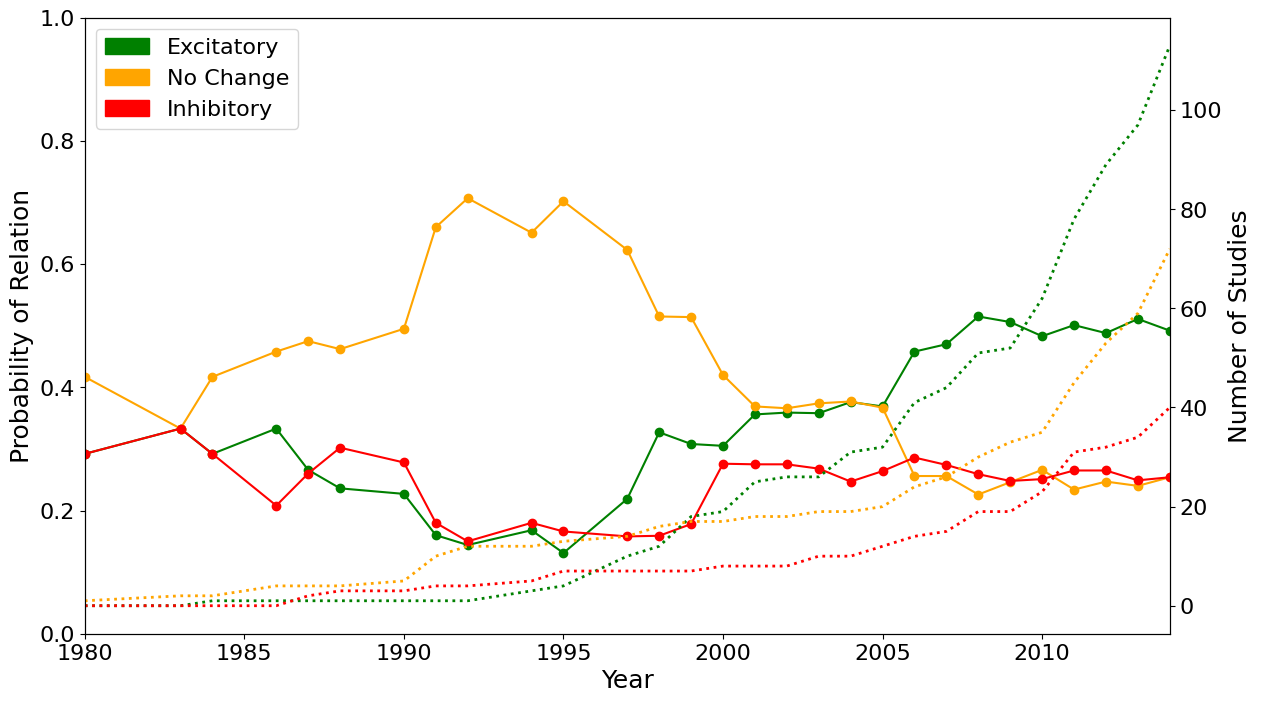

time: 440 ms (started: 2025-07-18 22:58:56 +08:00)


In [76]:
plot_cumulative_trends(score_df_yearly_dfs, start_display=1980, end_display=2014,save_path=None,source_data_path=None)